<a href="https://colab.research.google.com/github/YairYarden/Autonomous_Systems/blob/Project1/Mapping_and_Perception_for_an_autonomous_robot_assignment_1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mapping and Perception for an autonomous robot (0510-7951)**

#Exercise 1: 
---
**Part A** 

Experience with the KITTI dataset [**Robotic kit components**](https://www.cvlibs.net/datasets/kitti/) and [**pykitti tool**](https://pypi.org/project/pykitti/)

**Part B** 

Robot mapping based on [**probability occupancy grid**](https://ieeexplore.ieee.org/document/8666170)

**Part C** 

Sensor fusion and Road segemenation based on [**DeepLABv3+**](https://arxiv.org/abs/1703.06870) neural network

-------------------------------------

**Instructions**

1. Fill in the code the "TODO" section

2. **Please copy all the results to the report:**
  - Outputs- Images, tables, scores,etc
  - Performace, analysis and your explanations. 
  - Attach the completed notebook to the report package. 
3. Download and extract project data to your Google Drive

  1.   Install Google Drive on your desktop.
  2.   Save this notebook to your Google Drive by clicking `Save a copy in Drive` from the `File` menu.
  3. Go to [**KITTI dataset**](http://www.cvlibs.net/datasets/kitti/) ,and download your specific records (chose "sync" recording)
  5. Load the record to you goole drive account. Mount the recorcds to the notebook.
  6. The git include example of records ('0117'), you can use it to learn how to arrange the format folders for pykitti toolbox.

Good luck!

###REFERENCES

[1] The full KITTI datased can be accessed here: http://www.cvlibs.net/datasets/kitti/.

[2] KITTI Dataset paper: A. Geiger, P. Lenz, C. Stiller and R. Urtasun, "Vision meets Robotics: The KITTI Dataset," International Journal of Robotics Research (IJRR), vol. 32, no. 11, pp. 1231-1237 2013.

[3] Description of Occupancy Grid Map (OGM) estimation: Z. Luo, M. V. Mohrenschilt and S. Habibi, "A probability occupancy grid based approach for real-time LiDAR ground segmentation," IEEE Transactions on Intelligent Transportation Systems, vol 21, no. 3, pp. 998–1010, Mar. 2020.

[4] Paper of DeepLab v3+ for image segmentation: L. C. Chen, Y. Zhu, G. Apandreou, F. Schroff and H. Adam, “Encoder-decoder with atrous separable convolution for semantic image segmentation,” ECCV 2018 Lecture Notes in Computer Science, vol. 11211, pp. 833–851, 2018.

[5] DeepLab v3+ paper via arXiv: https://arxiv.org/abs/1802.02611.

[6] DeepLab v3+ repository: https://github.com/tensorflow/models/tree/master/research/deeplab.

[7] This tutorial use pykitti module to load the KITTI dataset: https://github.com/utiasSTARS/pykitti.

In [3]:
#TODO#

# Name of student:
# ID
# Record number:

In [4]:
## To import google drive, write this code in code section of colab and run it
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## PREPARATION

In [5]:
!git clone https://github.com/orfaig/course_ex1.git


Cloning into 'course_ex1'...
remote: Enumerating objects: 897, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 897 (delta 8), reused 49 (delta 6), pack-reused 842
Receiving objects: 100% (897/897), 186.59 MiB | 34.45 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [6]:
# First- install pykitti
!pip install pykitti

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
#second- install the other dependencies
!pip install -r course_ex1/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pykitti
import tensorflow as tf
from sklearn.linear_model import RANSACRegressor
from scipy import stats

In [4]:
import pymap3d as pm
import pandas as pd
#import getopt, os, sys, csv, numpy as np
import open3d as o3d
import plotly.graph_objects as go

In [7]:
### Load KITTI Data

# from my google drive (example)
basedir = 'gdrive/MyDrive/Autonomous_Systems_05107951/'
date = '2011_09_26'
drive = '0095'



#directly from colab
#basedir = 'course_ex1/raw_data/'
#date = '2011_09_26'
#drive = '0117'

data = pykitti.raw(basedir, date, drive)



In [8]:
# *********************   LLA Coordinates  *********************
fig_dir_path = os.getcwd() + "/Results/"
if not os.path.exists(fig_dir_path):
    os.makedirs(fig_dir_path)

#Part A: Geodetic coordinate system and the KITTI dataset

Helpful functions

In [5]:
def unpack_params(dataset):
    lons = [i.packet.lon for i in dataset.oxts]
    lats = [i.packet.lat for i in dataset.oxts]
    alts = [i.packet.alt for i in dataset.oxts]
    num_sats = [i.packet.numsats for i in dataset.oxts]
    pitches = [i.packet.pitch for i in dataset.oxts]
    rolls = [i.packet.roll for i in dataset.oxts]
    yaws = [i.packet.yaw for i in dataset.oxts]
    times = dataset.timestamps
    accs = [i.packet.pos_accuracy for i in dataset.oxts]
    return lons, lats, alts, num_sats, accs, pitches, rolls, yaws, times

In [9]:
lons, lats, alts, num_satsa, accs, pitches, rolls, yaws, times = unpack_params(data)

(1.b)
Print the trajectory on google maps using gmplot!

In [14]:
import gmplot

#TODO -Print the trajectory on google maps (hint- use gmplot.GoogleMapPlotterp)
gmap = gmplot.GoogleMapPlotter(lats[0], lons[0], zoom=18, apikey="")
gmap.plot(lats, lons, "cornflowerblue", edge_width=3.0)

# open the file Trajectory.html on chrome and see the trajectory on google maps
gmap.draw("route.html")



(1.c)

In [22]:
# load vehicle velocities
def load_vehicle_vel_singleIdx(data,idx,old_idx):
  #calc differce time (total_seconds) per frames:
  delta_t = (times[idx] - times[old_idx]).total_seconds() #TODO
  
  # read angular velocities: vf/s + vr/s (hint- vl is the opposite to vr)
  packet = data.oxts[idx].packet
  vf =  packet.vf #TODO (forawrd velocity)
  vr =  -packet.vl #TODO (angular velocity of the right side)

  # calc angular velocities per frame: vf/frame + vr/frame
  vfs = vf * delta_t #TODO
  vrs = vr * delta_t #TODO

  # calc yaw (substruct the initial yaw)
  pose_y = packet.yaw - data.oxts[0].packet.yaw #TODO

  return (vfs,vrs,pose_y)

def load_vehicle_vel_all(data):
  dataLen = len(data)
  vfs_array = np.zeros(dataLen)
  vrs_array = np.zeros(dataLen)
  pose_y_array = np.zeros(dataLen)
  for idx in range(len(data)-1):
    vfs_array[idx], vrs_array[idx], pose_y_array[idx] = load_vehicle_vel_singleIdx(data,idx+1,idx)

  return (vfs_array,vrs_array,pose_y_array)  


In [11]:
def Extarct_ENU_NED(lats,lons, alts):
    """
  
  :LLA coordinates from pykitti.raw()
  :return: ENU_coords_array,NED_coords_array
  """

    dataLength = len(lats)

    #calc- trajectory in ENU (HINT- use pm.geodetic2enu)    
    ENU_coords_array = np.zeros((dataLength,3))
    for i in range(dataLength):
      ENU_coords_array[i,:] = pm.geodetic2enu(lats[i], lons[i], alts[i],lats[0],lons[0],alts[0] )

    #calc- trajectory in NED (HINT- use pm.geodetic2ned)
    NED_coords_array = np.zeros((dataLength,3))
    for i in range(dataLength):
      NED_coords_array[i,:] = pm.geodetic2ned(lats[i], lons[i], alts[i],lats[0],lons[0],alts[0] )

    return ENU_coords_array,NED_coords_array

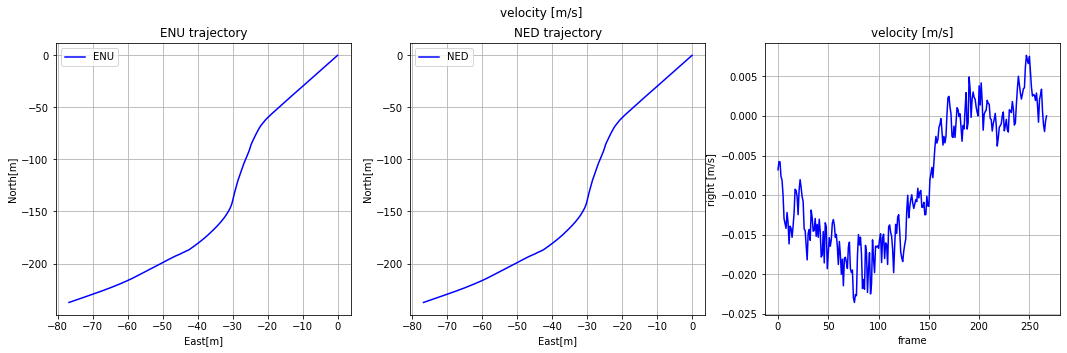

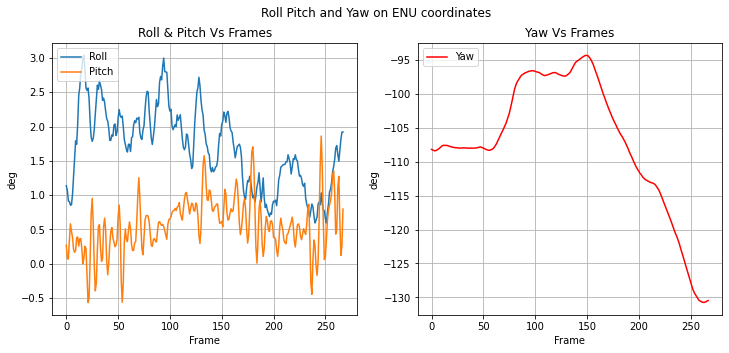

In [31]:
# Extract ENU & NED Coords
ENU_coords_array,NED_coords_array = Extarct_ENU_NED(lats, lons, alts)

# plotting positions
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(18, 5))
fig.suptitle('Trajectory on ENU')
ax1.plot(ENU_coords_array[:, 0],ENU_coords_array[:, 1], color="blue")
ax1.set_title('ENU trajectory')
ax1.set(xlabel='East[m]', ylabel='North[m]')
ax1.grid()
ax1.legend(["ENU"], loc='upper left')

fig.suptitle('Trajectory on NED')
ax2.plot(NED_coords_array[:, 1],NED_coords_array[:, 0], color="blue")
ax2.set_title('NED trajectory')
ax2.set(xlabel='East[m]', ylabel='North[m]')
ax2.grid()
ax2.legend(["NED"], loc='upper left')

# Extract velocity arrays
(vfs_array,vrs_array,pose_y_array) = load_vehicle_vel_all(data)

fig.suptitle("velocity [m/s]")
ax3.plot(vrs_array, color="blue")
ax3.set_title('velocity [m/s]')
ax3.set(xlabel='frame', ylabel='right [m/s]')
ax3.grid()

# plotting  orientation
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 5))
fig.suptitle("Roll Pitch and Yaw on ENU coordinates")
ax1.plot(np.array(rolls)/np.pi*180)
ax1.plot(np.array(pitches)/np.pi*180)
ax1.set_title('Roll & Pitch Vs Frames')
ax1.set(xlabel='Frame', ylabel='deg')
ax1.legend(["Roll","Pitch"],loc='upper left')
ax1.grid()
ax2.plot(np.array(yaws)/np.pi*180,color='r')
ax2.set_title('Yaw Vs Frames')
ax2.set(xlabel='Frame', ylabel='deg')
ax2.legend(["Yaw"], loc='upper left')
ax2.grid()
plt.savefig(fig_dir_path + "/" + "Roll Pitch and Yaw on ENU coordinates.png")

(1.d)

In [ ]:

#PlotSatellites Number  

def PlotSatellitesNumber(dataset):
  """
  plotting and saving the satellites number
  :param dataset: dataset from pykitti.raw()
  :param data_sequence: the video number 
  :return: None
  """

  #TODO# (hint-use: dataset.oxts[i].packet.numsats)
  plt.figure()
  plt.title("Number of receiving satellites Vs Frames")
  plt.plot(satellites_num)
  plt.xlabel("Frame")
  plt.ylabel("Number of receiving satellites")
  plt.grid()
  plt.savefig(fig_dir_path+"/"+"Number of receiving satellites Vs Frames.png")

(1.e)

In [ ]:
##Load point cloud data (LiDAR) and Image

def load_data(data,idx):
  ### Get the image data

  img_raw=#TODO (hint- use get_cam2 in pykitti)

  ### Get the LiDAR data (only x,y,z without the intensity) , (hint use get_velo )
  lidar_raw= #TODO

  return img_raw,lidar_raw

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

#idx=#TODO
img_raw,lidar_raw = load_data(data,idx)
pc=lidar_raw.T
### Visualize
dataf = []
x=pc[0,:];
point_size = np.full(x.shape, 2)
fig = px.scatter_3d(x=#TODO, y=#TODO, z=#TODO, size=point_size, opacity=1)
dataf = [go.Scatter3d(x=#TODO, y=#TODO, z=#TODO, mode="markers", marker=dict(size=2,color=pc[2,:],colorscale='Viridis'))]
mega_centroid = np.average(pc, axis=1)
mega_max = np.amax(pc, axis=1)
mega_min = np.amin(pc, axis=1)
lower_bound = mega_centroid - (np.amax(mega_max - mega_min) / 2)
upper_bound = mega_centroid + (np.amax(mega_max - mega_min) / 2)

show_grid_lines=True
# Setup layout
grid_lines_color = 'rgb(127, 127, 127)' if show_grid_lines else 'rgb(30, 30, 30)'
layout = go.Layout(scene=dict(
        xaxis=dict(nticks=8,
                range=[lower_bound[0], upper_bound[0]],
                showbackground=True,
                backgroundcolor='rgb(30, 30, 30)',
                gridcolor=grid_lines_color,
                zerolinecolor=grid_lines_color),
        yaxis=dict(nticks=8,
                range=[lower_bound[1], upper_bound[1]],
                showbackground=True,
                backgroundcolor='rgb(30, 30, 30)',
                gridcolor=grid_lines_color,
                zerolinecolor=grid_lines_color),
        zaxis=dict(nticks=8,
                range=[lower_bound[2], upper_bound[2]],
                showbackground=True,
                backgroundcolor='rgb(30, 30, 30)',
                gridcolor=grid_lines_color,
                zerolinecolor=grid_lines_color),
        xaxis_title="x (meters)",
        yaxis_title="y (meters)",
        zaxis_title="z (meters)"
    ),
    margin=dict(r=10, l=10, b=10, t=10),
    paper_bgcolor='rgb(30, 30, 30)',
    font=dict(
        family="Courier New, monospace",
        color=grid_lines_color
    ),
    legend=dict(
        font=dict(
            family="Courier New, monospace",
            color='rgb(127, 127, 127)'
        )
    )
)

fig = go.Figure(data=dataf,layout=layout)
fig.show()

#Part B: Probabilistic Occupancy Grid

(B.1.a)

In [ ]:
def Filter_PC(lidar_raw):
  
  ### Only use LiDAR points that are below the sensor (set threshold)
  ### Only use LiDAR points that are at least 2.5 m away from the sensor 

  lidar_raw_obstacles= #TODO (all the point clouds above ~30 cm off the ground- obstacles)

  lidar_raw_road= #TODO (free path under the threshold), ### use same threshold to extarct the point clounds of the estimate road

  return lidar_raw_obstacles,lidar_raw_road


In [ ]:
idx=1
img_raw,lidar_raw = load_data(data,idx)
lidar_raw,lidar_raw_road=Filter_PC(lidar_raw)
### Visualize
fig,axs = plt.subplots(2,1,figsize=(15,12))
axs[0].imshow( #TODO)
axs[1].scatter(lidar_raw[:,0],lidar_raw[:,1],c=-lidar_raw[:,2],marker='.')
axs[1].scatter(lidar_raw_road[:,0],lidar_raw_road[:,1],c='b',marker='.')
axs[1].scatter(0,0,c='r',marker='x')
axs[1].set_title("Naive method for driveable path segmentation")
axs[1].set_xlim( #TODO,#TODO)
axs[1].set_ylim(#TODO,#TODO)
axs[1].axis('scaled')
axs[1].grid()
plt.show()

In [ ]:
(B.1.b)

The Occupancy Grid Map (OGM) in this tutorial is estimated with the procedure described in [3]. OGM is a grid-based (image-like) map where each of its cell/pixel contains probability of that cell occupied by any obstacle. 

To update the OGM with the most recent measurement, the LiDAR points need to be converted to the similar grid format. This grid is called the scan grid (SG).

Take a look at the figure of a SG below. In the figure, the purple point is a sample of the LiDAR measurements. There are three conditions to fill the SG.
1. Black cells: The cells around the point (cells that are radially located at +-ALPHA and angularly located at +-BHETA from the point) are given probability = 0.8 which means that they are likely to be occupied.
2. White cells: The cells that are located between the origin/sensor and the measured point are given probability = 0.2 which means that they are likely to be free.
3. Gray cells: The other cells, including the ones behind the points, are given probability = 0.5 which means that we can't infer whether they are free or occupied.


<br>
<center><img src="https://raw.githubusercontent.com/orfaig/course_ex1/146218cc7ffabae80fe546b68ba03a6073fbefa2/figures/sg_gen.png" width=300px></center>
</br>


The efficient implementation of the SG creation is not straightforward. In this tutorial, we create the SG in spherical coordinate first. After the spherical SG is filled, then it is converted to cartesian coordinate. 


There are several parameters that need to be defined:
- ALPHA - The radial resolution when converting LiDAR data to grid map in m (explained later).
- BHETA - The angular resolution when converting LiDAR data to grid map in radian (explained later) .
- RESOLUTION - The resolution of the grid map in meter.
- MAX_RANGE - Maximum range of LiDAR points that will be converted to grid map.
- MAP_WIDTH - Width of the map from side to side in meter.
- SPHERICAL2CARTESIAN_BIAS - An adjustment needed due to some errors when converting the spherical grid map to the cartesian grid map.

## Map Initialization

The OGM is initialized with probability of all of its cells = 0.5

In [ ]:
### Some derived parameters
# OOR_MASK = A mask to filter out measurements that are out of MAX_RANGE
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

### Initialize OGM
ogm_time_0 = np.ones((MAP_SIZE_Y,MAP_SIZE_X)) * #TODO

### Visualize
# Yes, it's still empty
plt.figure(figsize=(6, 6))
plt.imshow(ogm_time_0,cmap='gray',vmax=1)
plt.show()

In [ ]:
ALPHA = #TODO
BHETA = #TODO*np.pi/180
RESOLUTION = #TODO
MAX_RANGE = #TODO
MAP_WIDTH = #TODO
SPHERICAL2CARTESIAN_BIAS = #TODO

Implementation of a grid on a single scan:

In [ ]:
def generate_measurement_ogm(lidar_in,ogm_shape):
  ### Calculate the position of LiDAR points in spherical coordinate
  ### build zeros matrix in size 2 for range and angular
  rphi_meas = np.zeros((lidar_in.shape[0],2))
  ### set the distance of x,y in col 1. use ALPH
  rphi_meas[:,1] = #TODO
  ### set the angular in col 0. use arctan2 and don't forget to add pi, and to use BHETA
  rphi_meas[:,0] = #TODO

   ### unique repatative points in same line of sight
  rphi_meas =  #TODO

  ### Set the cells below the maximum range to zero
  rphi_meas = #TODO

  ### set zero the cells that below the max angular
  rphi_meas = #TODO

  ### Initalize the spherical scan grid size
  sg_ang_bin = int(2*np.pi/BHETA)
  sg_rng_bin = int(MAX_RANGE/ALPHA)
  scan_grid = np.ones((#TODO,#TODO))
  
  # Initiation (Condition 1)
  #Initalize spherical probability #(hint- unknown probability value)
  #TODO 

  # Condition 2 - set the occupied probabilty value in the occupied cells
  #TODO 
  
  # Condition 3  set the free probabilty score to drivable path and to free line of sight w/o obstacles.
  for ang in range(sg_ang_bin):
    ang_arr = rphi_meas[rphi_meas[:,0]==ang,1]
    if len(ang_arr) == 0: #case a- line of sight is clear
      #TODO 
    else:                 #case b- The line of sight is blocked, but the cells to the first occupied cell are clear. 
      #TODO 
  ### Convert the spherical scan grid to the cartesian one
  ogm_sz = (ogm_shape[1],ogm_shape[0])
  ogm_cen = (int(ogm_shape[1]/2),int(ogm_shape[0]/2))
  radius = (MAX_RANGE/RESOLUTION) + SPHERICAL2CARTESIAN_BIAS

  #use warpPolar to convert the polar map to cartesiaan (hint- use warpPolar, inputs: scan_grid,ogm shape ,ogm center ,range ,cv2.WARP_INVERSE_MAP)
  return ogm_step

## Display two single maps

In [ ]:
idx=0
img_raw1,lidar_raw1 = load_data(data,idx)
lidar_raw1,lidar_raw_road=Filter_PC(lidar_raw1)
ogm_time_1 = generate_measurement_ogm(lidar_raw1,ogm_time_0.shape)

idx2=1 
img_raw2,lidar_raw2 = load_data(data,idx2)
lidar_raw2,lidar_raw_road=Filter_PC(lidar_raw2)
ogm_time_2 = generate_measurement_ogm(lidar_raw2,ogm_time_0.shape)

# ### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm_time_1)*255).astype(np.uint8))
axs[1].imshow(img_raw1)
plt.show()

### Visualize
fig,axs = plt.subplots(2,2,figsize=(20,10))
axs[0][0].imshow(((1-ogm_time_1)*255).astype(np.uint8))
axs[0][0].set_title("frame 0")
axs[1][0].imshow(img_raw)
axs[0][1].imshow(((1-ogm_time_2)*255).astype(np.uint8))
axs[0][1].set_title("frame 1")
axs[1][1].imshow(img_raw2)
plt.show()

(B.1.c)

## Try First Update

The OGM is updated by the recent scan grid using Bayesian update. According the derivation in the paper, if we initiate the OGM as empty grid, the $i$-th cell of OGM can be updated with this simple formula

\begin{align}
L_{i,t} = L_{i,t-1} + L^{SG}_{i,t-1}
\end{align}

$L_{i,t}$ is the [logit](https://en.wikipedia.org/wiki/Logit) of the $i$-th cell of the updated OGM.

$L_{i,t-1}$ is the logit of the $i$-th cell of the previous OGM.

$L^{SG}_{i,t-1}$ is the logit of the $i$-th cell of the scan grid that are generated from the latest LiDAR points.  

Then, the usable OGM can be found by calculating the inverse-logit of $L_{i,t}$

In [ ]:
### Calculate the logit function
def logit(m):
  return #TODO 

### Calculate the inverse logit function
def inverse_logit(m):
  return #TODO 

### Update the prior OGM with the scan grid (new_ogm)
def update_ogm(prior_ogm,new_ogm):
  ## a.  calc logit map
  logit_map =#TODO 
  ## b.  inverse to probability space
  out_ogm = #TODO  
  ## c. apply saturation 
  #TODO
  return out_ogm

ogm_updated_1 = update_ogm(ogm_time_1,ogm_time_0)

### Visualize
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(((1-ogm_updated_1)*255).astype(np.uint8))
plt.show()

In [ ]:
### Visualize Point cloud, probabilty and logit space
fig,axs = plt.subplots(1,3,figsize=(20,10))
axs[0].scatter(lidar_raw[:,0],lidar_raw[:,1],c=lidar_raw[:,2],marker='.',s=0.1)
axs[0].scatter(0,0,c='r',marker='x')
axs[0].set_title("Point cloud (Z>TH)")
axs[0].set_xlim(-80,80)
axs[0].set_ylim(-80,80)
axs[0].axis('scaled')
axs[0].set_ylabel('y')
axs[0].set_xlabel('x (heading')
axs[0].grid()
colorbar=axs[1].imshow(ogm_step1)
fig.colorbar(colorbar,ax=axs[1],fraction=0.046, pad=0.1)
axs[1].set_title("scan grid:\n Probability represnetation")
axs[2].imshow(logit(ogm_step1))
colorbar=axs[2].imshow(logit(ogm_step1),cmap='seismic')
fig.colorbar(colorbar,ax=axs[2],fraction=0.046, pad=0.1)
axs[2].set_title("scan grid:\n Logit represnetation")
plt.show()

Example
<br>
<center><img src="https://raw.githubusercontent.com/orfaig/course_ex1/146218cc7ffabae80fe546b68ba03a6073fbefa2/figures/PC_prob_logit.png" width=1200px></center>
</br>

(B.1.d)

##Shift the OGM!

Shift the OGM according to the next pose

In [ ]:
# Shift the map according the vehicle's poses 
def shift_pose_ogm(ogm, init, fin):
  ogm_o = ogm.copy()
  trs_m = np.array([[init[0]],[init[1]]])
  delta_theta = (fin[2] - init[2])
  delta = np.array([trs_m[1,0]/RESOLUTION,trs_m[0,0]/RESOLUTION,0])

  M = np.array([[1,0,-delta[0]],[0,1,delta[1]]])
  dst = cv2.warpAffine(ogm_o,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)
  M = cv2.getRotationMatrix2D((ogm_o.shape[1]/2+0.5,ogm_o.shape[0]/2+0.5),-delta_theta/np.pi *180 ,1) #Angle of Rotation. Angle is positive for anti-clockwise and negative for clockwise
  dst = cv2.warpAffine(dst,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)
  return dst

In [ ]:
# Pose of two frames - frame 1 and frame 2
pose1 = load_vehicle_vel(data,idx,idx)
pose2 = load_vehicle_vel(data,idx1,idx)

In [ ]:
shift_ogm_time_1 = shift_pose_ogm(ogm_time_1,pose1,pose2)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm_time_1)*255).astype(np.uint8))
axs[0].set_title('Before')
axs[1].imshow(((1-shift_ogm_time_1)*255).astype(np.uint8))
axs[1].set_title('After')
plt.show()

##Update next frame

In [ ]:
ogm_updated_2 = update_ogm(shift_ogm_time_1,ogm_time_2)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].imshow(((1-ogm_time_2)*255).astype(np.uint8))
axs[0].set_title("frame 2")
axs[1].imshow(((1-ogm_updated_2)*255).astype(np.uint8))
axs[1].set_title("frame 1+2")
plt.show()



##Robot mapping!

In [ ]:
(B.2)

## Pre-processing

1.   Transform the point cloud to INS location.
2.   Align the point cloud based on IMU inputs.

In [ ]:
def rotx(t):
    """Rotation about the x-axis."""
    return #TODO

def roty(t):
    """Rotation about the y-axis."""
    return #TODO


def rotz(t):
    """Rotation about the z-axis."""
    return #TODO

velo_to_imu_calibration = #TODO (hint- use inverse)

In [ ]:
def transform_from_rot_trans(R, t):
    """Transforation matrix from rotation matrix and translation vector."""
    R = R.reshape(3, 3)
    t = t.reshape(3, 1)
    return np.vstack((np.hstack([R, t]), [0, 0, 0, 1]))

##Repeat the occupancy map process over all your scans/frames!!

In [ ]:
### Initialize OGM
Occupancy_map = np.ones((MAP_SIZE_Y,MAP_SIZE_X)) * 0.5

for idx_frame in range(#TODO):

  # Load data
  #TODO

  # filter point cloud of the obstacles! (height above threshould)
  #TODO

  #Transfrom point cloud to baselink (imu)
  #TODO

  #ego sphere (apply the inverse of roll and pitch on the point cloud) 
  #use roll and pitch matrix
  #use data.oxts.packet.roll and data.oxts.packet.pitch
  #TODO

  
  x_points = lidar_raw[:, 0]
  y_points = lidar_raw[:, 1]
  z_points = lidar_raw[:, 2]

  velo=np.vstack((x_points, y_points,z_points )).T

  if (idx_frame ==0):
    pose_prev = (0,0,0)
    prev_indx=idx_frame
  else:
   
    prev_indx=idx_frame-1
  
  #Occupancy map
  #pose = #TODO         (hint- use load_vehicle_vel )
  #shifted_ogm =#TODO   (hint- use shift_pose_ogm)  
  #ogm_step =#TODO      (hint- generate_measurement_ogm)
  #Occupancy_map =#TODO (hint- update_ogm)


  pose_prev=pose

  fig,axs = plt.subplots(2,2,figsize=(15,12))
  fig1 = plt.gcf()
  axs[0,0].imshow(img_raw)
  axs[0,0].set_title("Occupancy Map At Frame Number={:03}".format(idx_frame))
  axs[0,0].axis('scaled')
  axs[1,1].imshow(Occupancy_map)
  axs[1,1].scatter(500,500,c='r',marker='x')
  axs[1,1].axis('scaled')
  axs[1,1].set_title("Occupancy Map")
  axs[1,0].imshow(ogm_step)
  axs[1,0].scatter(500,500,c='r',marker='x')
  axs[1,0].set_title("Hitmap (scan grid)")
  axs[0,1].scatter(-lidar_raw[:,1],lidar_raw[:,0],c=lidar_raw[:,2],marker='.')
  axs[0,1].scatter(lidar_raw_road[:,1],lidar_raw_road[:,0],c='b',marker='.',s=0.1)
  axs[0,1].scatter(0,0,c='r',marker='x')
  axs[0,1].grid()
  axs[0,1].axis('scaled')
  axs[0,1].set_title("Naive method for road segmenation")
  axs[0,1].set_xlim(-80,80)
  axs[0,1].set_ylim(-80,80)
  plt.show()
  plt.draw()
  #fig1.savefig("%s/occupancy_map_frame_{:03}.png".format(idx_frame) % '/content/gdrive/MyDrive/Exp1/', dpi=100 )

Example
<br>
<center><img src="https://raw.githubusercontent.com/orfaig/course_ex1/146218cc7ffabae80fe546b68ba03a6073fbefa2/figures/naive_method_frame_3.png" width=1200px></center>
</br>

(B.2.g)

Apply threshoulds on the occupancy map:
The segmented maps should describe 3 types of cells: free, occluded and unknown.

In [ ]:
threshold_for_free=#TODO
threshold_for_Occupied=#TODO

### Visualize Segmented_occupancy_map
fig,axs = plt.subplots(1,3,figsize=(20,10))
axs[0].imshow(ogm_step)
colorbar=axs[0].imshow(ogm_step)
fig.colorbar(colorbar,ax=axs[0],fraction=0.046, pad=0.1)
axs[0].set_title("scan grid")


colorbar=axs[1].imshow(Occupancy_map)
fig.colorbar(colorbar,ax=axs[1],fraction=0.046, pad=0.1)
axs[1].set_title("Occupancy_map")
axs[1].axis('scaled')
axs[1].imshow(Occupancy_map)

## segmented map!

Occupancy_map_final=np.ones((MAP_SIZE_Y,MAP_SIZE_X)) * #TODO
Occupancy_map_final[Occupancy_map < threshold_for_free]=#TODO
Occupancy_map_final[Occupancy_map > threshold_for_Occupied]=#TODO

axs[2].imshow(Occupancy_map_final)
colorbar=axs[2].imshow(Occupancy_map_final,cmap='PRGn')
fig.colorbar(colorbar,ax=axs[2],fraction=0.046, pad=0.1)
axs[2].set_title("Segmented_occupancy_map")
plt.show()

Example
<br>
<center><img src="https://raw.githubusercontent.com/orfaig/course_ex1/146218cc7ffabae80fe546b68ba03a6073fbefa2/figures/segmented_map.png" width=1200px></center>
</br>

(C.1)

# Part C: Sensor fusion and Road segemenation

The goal of the perception system is to extract the information about the round where the vehicle is operating on. This road information will be used to filter out LiDAR points that hit the road so that it can be used for mapping purpose. To extract the information about where the road is, we use deep learning-based image segmentation technique that will be applied to the camera image.

## Get Callibration Data

Two callibrated parameters that we need:
- LiDAR to camera extrinsic matrix - The matrix (4x4) that will be used to transform the LiDAR points to the camera 3D coordinate frame.
-  Camera intrinsic matrix - The mastrix (3x3) that will be used to calculate the coordinate of pixels that representat 3D points in camera coordinate.

The calibrated parameters are already provided in the dataset. For details, please take a look at [this explanation](https://www.mathworks.com/help/vision/ug/camera-calibration.html) from Mathworks.

In [ ]:
### Retrieve the provided calibration data
lidar2cam_extrinsic = #TODO 
camera_intrinsic =  #TODO

print('Lidar to camera extrinsic matrix: ')
print(lidar2cam_extrinsic)
print()
print('Camera intrinsic matrix: ')
print(camera_intrinsic)

## Load Camera and LiDAR Data

Coordinate system of
- Camera = x: right, y: down, z: forward
- LiDAR = x: forward, y: left, z: up

In this tutorial, camera coordinate system is used. Therefore, the LiDAR points need to be transformed to the camera coordinate frame. Use the LiDAR to camera extrinsic matrix!

The extrinsic matrix can be written as $\begin{bmatrix} R|t \end{bmatrix}$, a combinarion of a rotation matrix $R$ and a translation vector $t$. Given that the point in LiDAR coordinate is $(X_L,Y_L,Z_L)$, its coordinate in camera 3D frame, $(X_C,Y_C,Z_C)$ is

\begin{align}
\begin{bmatrix}
X_C \\
Y_C \\
Z_C \\
1 \\
\end{bmatrix}= 
\begin{bmatrix} R|t \end{bmatrix}
\begin{bmatrix}
X_L \\
Y_L \\
Z_L \\
1 \\
\end{bmatrix}
\end{align}



In [ ]:
def filterLidarbelowsensor(lidar_raw):

  ### Only use LiDAR points that are at least 2.5 m away (hint udr norm to find the distance)
  #TODO
  
   ### find LiDAR points that are below the sensor (z=0)
  #TODO

  return lidar_raw

### Transform the LiDAR points into camera coordinate
def transform_coordinate(lidar_points,extrinsic_matrix):
  inp = lidar_points.copy()
  #TODO (multiply extrinsic_matrix with lidar_points )
  return inp[:,:3]



In [ ]:
idx=0
idx1=1
#load the data (hint- use load data)
img_raw,lidar_raw = #TODO

#filter Lidar below sensor (hint-  filterLidarbelowsensor)
lidar_raw_filter=#TODO

#transform point cloud to camera coordinate 
lidar_raw_cam = transform_coordinate(lidar_raw_filter,lidar2cam_extrinsic)

# same as indx
lidar_raw_cam1=#TODO

### Visualize
fig,axs = plt.subplots(2,2,figsize=(15,12))
axs[0,0].imshow(img_raw)
axs[0,1].scatter(lidar_raw_cam[:,0],lidar_raw_cam[:,2],c=-lidar_raw_cam[:,1],marker='.')
axs[0,1].scatter(0,0,c='r',marker='x')
axs[0,1].set_title("point cloud includes the road!")
axs[0,1].axis('scaled')
axs[1,0].imshow(img_raw1)
axs[1,1].scatter(lidar_raw_cam1[:,0],lidar_raw_cam1[:,2],c=-lidar_raw_cam1[:,1],marker='.')
axs[1,1].scatter(0,0,c='r',marker='x')
axs[1,1].axis('scaled')
plt.show()

## Project the LiDAR Points to the Camera

To transfer the road information from image to LiDAR, we need to project the LiDAR points to the camera image. Use the camera intrinsic matrix!

The camera intrinsic matrix is denoted as $K$. The coordinate of pixel, $(u,v)$, that represents a point in 3D space, $(X_C,Y_C,Z_C)$, in image frame can be calculated with 

\begin{align}
\begin{bmatrix}
u\times w \\
v\times w \\
w \\
\end{bmatrix}= 
K
\begin{bmatrix}
X_C \\
Y_C \\
Z_C \\
\end{bmatrix}
\end{align}

<br>
<center><img src="https://docs.opencv.org/4.5.0/pinhole_camera_model.png" width=400px></center>
</br>

Sumber gambar: [OpenCV Docs](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html)

(C.1.b)

In [ ]:
def project_lidar2cam(lidar_raw_cam,camera_intrinsic,img_raw_size):
  #Inputs: 
  #lidar_in_cam: lidar raw data in camera axis coordiantes: x: right, y: down, z: forward
  #camera_intrinsic,img_raw_size
  
  ### 1. Filter out data behind the camera (hint- take only the forward points (z>0 in camera coordinates) and not the backward points)
  #TODO
  lidar_raw_cam = np.concatenate((lidar_raw_cam,np.ones((lidar_in_cam.shape[0],1))),axis=1)
  lidar_in_cam = lidar_raw_cam[lidar_raw_cam[:,2]>0]

  ### 2. Project points to the image
  # hint-1 (use camera_intrinsic )
  # hint-2 convert wx,wy and w to image coordinates("lidar 2d"): u,v (divide u=x/w and v=y/w )
  #TODO

  lidar_2d = #TODO
  lidar_2d = #TODO
  lidar_2d = lidar_2d.astype(int)

  ### 3. Filter out points that are outside image frame
  ## (hint- use maskH and maskv, see exaplation below)
  #TODO
  lidar_2d = #TODO
  lidar_in_cam_img = #TODO

  return #lidar_2d (image coordinates),lidar_in_cam_img[:,:3] (camera coordinates, but only the PC in the image FOV)

img_raw_size = img_raw.shape

lidar_2d,lidar_in_cam_img = project_lidar2cam(lidar_raw_cam,camera_intrinsic,img_raw_size)
lidar_2d1,lidar_in_cam_img1 = project_lidar2cam(lidar_raw_cam1,camera_intrinsic,img_raw_size)

### Visualize
print(f'Original image size: {img_raw.shape}')

img = img_raw.copy()
axs = 2
axs_log = np.log(lidar_in_cam_img[:,axs]-np.min(lidar_in_cam_img[:,axs])+1)
max_axs = np.max(axs_log)
for pt,z in zip(lidar_2d,axs_log):
    color_z = z*255/max_axs
    c = (color_z,0,0)
    cv2.circle(img,tuple(pt[:2].astype(int)),1,c,-1)

img1 = img_raw1.copy()
axs = 2
axs_log1 = np.log(lidar_in_cam_img1[:,axs]-np.min(lidar_in_cam_img1[:,axs])+1)
max_axs1 = np.max(axs_log1)
for pt,z in zip(lidar_2d1,axs_log1):
    color_z = z*255/max_axs1
    c = (color_z,0,0)
    cv2.circle(img1,tuple(pt[:2].astype(int)),1,c,-1)

fig,axs = plt.subplots(2,1,figsize=(15,7))
axs[0].imshow(img)
axs[1].imshow(img1)
plt.show()

Example
<br>
<center><img src="https://raw.githubusercontent.com/orfaig/course_ex1/146218cc7ffabae80fe546b68ba03a6073fbefa2/figures/project_lidar_camera.png" width=1200px></center>
</br>

(C.2.a)

## Image Cropping

The deep learning model (DeepLab v3+) was trained with cropped images from KITTI dataset with ratio 4:3 (W:H), which was resized further to 513 x 513 images. It will work better if we use the same size of images.

Parameter:
- CROP_RH - The height ratio of target image size
- CROP_RW - The width ratio of target image size

In [ ]:
### Function to crop the image according to the target size ratio
### The image will be cropped at the center
def crop_data(img_in,lidar_2d_in,lidar_in_cam_img,rh,rw):
  lidar_2d = lidar_2d_in.copy()
  lidar_in_cam_img = lidar_in_cam_img.copy()
  img = img_in.copy()

  ### Crop the image
  dim_ori = np.array(img.shape)
  cent = (dim_ori/2).astype(int)
  if dim_ori[0]/dim_ori[1] == rh/rw:
      crop_img = img
    
  # If Height <= Width
  elif dim_ori[0] <= dim_ori[1]:
      cH2 = dim_ori[0]
      cW2 = cH2*rw/rh
      cW = int(cW2/2)
      crop_img = img[:,cent[1]-cW:cent[1]+cW+1]

  # If Height > Width
  else:
      cW2 = dim_ori[1]
      cH2 = cW2*rh/rw
      cH = int(cH2/2)
      crop_img = img[cent[0]-cH:cent[0]+cH+1,:]

  ### Filter out LiDAR points outside cropped image

  
  cW = cW2/2 # horizontal size in pixels
  cH = cH2/2 # vertical size in pixels
  centH = cent[0] #center in horizontal
  centW = cent[1] #center in vertical

  maskH = #TODO (hint horizontal: lidar_2d[:,1]) 
  maskW = #TODO (hint vertical: lidar_2d[:,0]) 
  mask = np.logical_and(maskH,maskW)

  lidar_2d_crop = lidar_2d[mask,:]
  lidar_in_cam_img_crop = lidar_in_cam_img[mask,:]

  cent = np.array((centW-cW,centH-cH,0)).reshape((1,3))
  lidar_2d_crop = lidar_2d_crop - cent

  return crop_img, lidar_2d_crop.astype(int), lidar_in_cam_img_crop

### Cropped image's size ratio
CROP_RH = 3 # Height ratio
CROP_RW = 4 # Width ratio
crop_img,lidar_2d_crop,lidar_in_cam_img_crop = crop_data(img_raw,lidar_2d,lidar_in_cam_img,CROP_RH,CROP_RW)
crop_img1,lidar_2d_crop1,lidar_in_cam_img_crop1 = crop_data(img_raw1,lidar_2d1,lidar_in_cam_img1,CROP_RH,CROP_RW)

### Visualize
img = crop_img.copy()
axs = 2
axs_log = np.log(lidar_in_cam_img_crop[:,axs]-np.min(lidar_in_cam_img_crop[:,axs])+1)
max_axs = np.max(axs_log)
for pt,z in zip(lidar_2d_crop,axs_log):
    color_z = z*255/max_axs
    c = (color_z,0,0)
    cv2.circle(img,tuple(pt[:2].astype(int)),1,c,-1)

img1 = crop_img1.copy()
#TODO (same as img above)

fig,axs = plt.subplots(1,2,figsize=(10,7))
axs[0].imshow(img)
axs[1].imshow(img1)
plt.show()

Example
<br>
<center><img src="https://raw.githubusercontent.com/orfaig/course_ex1/146218cc7ffabae80fe546b68ba03a6073fbefa2/figures/crop_lidar_camera.png" width=400px></center>
</br>

(C.2.b)

## Road Segmentation

Process the camera image with image segmentation-based deep learning method to get regions that correspond to the road. Specifically, we use DeepLab v3+ model that has been trained before with KITTI dataset. The model has been trained on image with size 513 x 513. Thus, the input image need to be resized first before being processed by the model. [Read this article](https://rockyshikoku.medium.com/train-deeplab-v3-with-your-own-dataset-13f2af958a75) if you want to know how to train your own DeepLab v3+ model. 

Parameters:
- DEEPLAB_MODEL_PATH - Path to the model protobuff (.pb) file
- DEEPLAB_INPUT_SIZE - Input size of the model

Now, by projecting the LiDAR points to the segmented image, we can know which points that correspond to the road. 

In [ ]:
### Function to process the image with DeepLabv3+
def process_images(img_in, sess, target_size=513, probability_threshold=0.5):
  INPUT_TENSOR_NAME = 'ImageTensor:0'
  PROB_TENSOR_NAME = 'SemanticProbabilities:0'
  INPUT_SIZE = target_size

  image = img_in.copy()
  sz = image.shape
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Resize input image to target size
  if INPUT_SIZE == 0:
    resized_image = image.copy()
  else:
    resized_image = cv2.resize(image,(INPUT_SIZE,INPUT_SIZE))

  # Run deep learning inference
  batch_seg_map = sess.run(
      PROB_TENSOR_NAME,
      feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
  seg_map = (batch_seg_map[0][:,:,1]*255).astype(int)
  prob = np.array(seg_map, dtype=np.uint8)
  prob = cv2.resize(prob,(sz[1],sz[0]))

  # Create the prediction
  pred = prob.copy()
  msk_bin = prob >= (probability_threshold*255)
  pred[msk_bin] = 1
  pred[np.logical_not(msk_bin)] = 0

  # Ignore regions that are separated from the main road
  # This can reduce the amount of false detection
  # hint- use cv2.connectedComponents
  _,segm_reg = #TODO
  segm_reg = segm_reg.astype(float)
  segm_reg[segm_reg==0] = np.nan

  modes,_ = stats.mode(segm_reg.flatten(),axis=None,nan_policy="omit")
  mode = modes[0]
  pred[segm_reg!=mode] = 0
  
  return prob,(pred*255).astype(np.uint8)

### Load the model
DEEPLAB_MODEL_PATH = 'course_ex1/pretrained/deeplab_model.pb'

with open(DEEPLAB_MODEL_PATH, "rb") as f:
    graph_def = tf.compat.v1.GraphDef.FromString(f.read())
graph = tf.Graph()
with graph.as_default():
    tf.import_graph_def(graph_def=graph_def, name="")
sess = tf.compat.v1.Session(graph=graph)

DEEPLAB_INPUT_SIZE = 513
segm_prob,segm_pred = process_images(crop_img, sess, DEEPLAB_INPUT_SIZE, 0.5)
segm_prob1,segm_pred1 = process_images(crop_img1, sess, DEEPLAB_INPUT_SIZE, 0.5)



In [ ]:
### Visualize
segm_3ch = crop_img.copy()
for pt in lidar_2d_crop:
  pt = pt.astype(int)
  if segm_pred[pt[1],pt[0]] == 0:
    segm_3ch[pt[1],pt[0],0]=img[pt[1],pt[0],0]
    segm_3ch[pt[1],pt[0],1]=img[pt[1],pt[0],1]
    segm_3ch[pt[1],pt[0],2]=img[pt[1],pt[0],2]
    continue
  c = (255,0,0)
  cv2.circle(segm_3ch,tuple(pt[:2]),1,c,-1)


segm_3ch1 = crop_img1.copy()
for pt in lidar_2d_crop:
  pt = pt.astype(int)
  if segm_pred1[pt[1],pt[0]] == 0:
    continue
  c = (255,0,0)
  cv2.circle(segm_3ch1,tuple(pt[:2]),1,c,-1)


fig,axs = plt.subplots(1,2,figsize=(10,7))
axs[0].imshow(segm_3ch)
axs[1].imshow(segm_3ch1)
plt.show()

Example
<br>
<center><img src="https://raw.githubusercontent.com/orfaig/course_ex1/146218cc7ffabae80fe546b68ba03a6073fbefa2/figures/road_seg_image.png" width=400px></center>
</br>

In [ ]:
#Dispaly road segmenation on image
img_rgb = cv2.cvtColor(segm_pred,cv2.COLOR_GRAY2BGR)
img_rgb[segm_pred>0,0]=0
img_rgb[segm_pred>0,1]=20
img_rgb[segm_pred>0,2]=255

overlay_image =#TODO (hint-use  cv2.addWeighted function, crop img and img_rgb ) cv2.addWeighted(crop_img,0.9,img_rgb,0.8,1)
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(overlay_image,cmap='gray')
plt.show()

(C.3)

## LiDAR Road Filter

The road points set that are obtained from the previous step may contain false detection and obviously only contains point that are inside the camera field of view. We also need to detect road points that are outside this set!

To do this, fit a plane model (which will represent the road model) $Ax+By+Cz=1$ to the current road points. Any points that are outside the camera field of view and located near the road plane model can be also regarded as road points. RANSAC algorithm is applied when fitting the model to reduce the influence of outliers. Visit this [Wikipedia page](https://en.wikipedia.org/wiki/Random_sample_consensus) for more information about RANSAC.

Parameter:
- ROAD_HEIGHT_THRESHOLD - The maximum distance (in height axis) between a point to the road model to be considered as road point.

In [ ]:
### Get the plane model from the road points
def get_road_model_ransac(img_pred,lidar_in_cam_img_crop,lidar_2d_crop):

  #inputs: lidar_in_cam_img_crop- points cloud on the image in image coordinates

  #using the image and lidar2d to check which point cloud is on the road!
  lidar_in_road_lbl = [True if img_pred[pt[1],pt[0]] == 255 else False for pt in lidar_2d]


  # filter the road points from camera coordinate space!, the model is based on camera coordinate!
  lidar_in_road = lidar_in_cam_img_crop[lidar_in_road_lbl,:]

  Mininal_set_of_point=10; #optional, you can calibrate this value

  if len(lidar_in_road[:,[0,2]])<Mininal_set_of_point:
     #In the case of few points, there are not enough statistics so we simply use the previous model
    status=0
    road_model=None
  else: 
    # Estimate the road model 
    # (hint- use RANSACRegressor function, lidar_in_road and Mininal_set_of_point )
    # TODO             
    status=1

  #outputs: road_model and status (0- there is no model! ,1- new model)

  return road_model,status

In [ ]:
### Predict all LiDAR points as road or not
def filter_road_points(road_model,lidar_raw_cam,threshold=0.5):
  #inputs: trained road model by RANSACRegressor, lidar raw data in camera coordinates and threshould of road height(m)

  x = # TODO (hint-point cloud:  x and z axes ) 
  y_true = # TODO (hint-point cloud:  y axes ) 
  y_pred = # TODO (hint-model predict ) 
  delta_y =#TODO hint (absolute(y_true-y_pred))   np.absolute(y_true-y_pred).flatten()
  is_not_road =#TODO (hint- use threshold)
  lidar_out = #TODO (point cloud of the road)
  lidar_road = #TODO (point cloud of the rest objects)
  return lidar_out,lidar_road

road_height_threshold = 0.3 #optional, you can calibrate this value

road_model,status = get_road_model_ransac(segm_pred,lidar_in_cam_img_crop,lidar_2d_crop)
lidar_nonroad,lidar_road = filter_road_points(road_model,lidar_raw_cam,road_height_threshold)

road_model1,status1 = get_road_model_ransac(segm_pred1,lidar_in_cam_img_crop1,lidar_2d1)
lidar_nonroad1,lidar_road1 = filter_road_points(road_model1,lidar_raw_cam1,road_height_threshold)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].scatter(lidar_nonroad[:,0],lidar_nonroad[:,2],c=-lidar_nonroad[:,1],marker='.')
axs[0].scatter(lidar_road[:,0],lidar_road[:,2],c='b',marker='.')
axs[0].scatter(0,0,c='r',marker='x')
axs[0].axis('scaled')
axs[1].scatter(lidar_nonroad1[:,0],lidar_nonroad1[:,2],c=-lidar_nonroad1[:,1],marker='.')
axs[1].scatter(lidar_road1[:,0],lidar_road1[:,2],c='b',marker='.')
axs[1].scatter(0,0,c='r',marker='x')
axs[1].axis('scaled')
plt.show()

Now we can remove the road points from the LiDAR data and proceed to the mapping system.

(C.4)

## Robot mapping based on Deep Learning!!




In [ ]:
#Dispaly road segmenation on image
img_rgb = cv2.cvtColor(segm_pred,cv2.COLOR_GRAY2BGR)
img_rgb[segm_pred>0,0]=0
img_rgb[segm_pred>0,1]=20
img_rgb[segm_pred>0,2]=255

overlay_image =#TODO (hint-use  cv2.addWeighted function, crop img and img_rgb ) cv2.addWeighted(crop_img,0.9,img_rgb,0.8,1)
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(overlay_image,cmap='gray')
plt.show()

##Pre-processing

In [ ]:
#Pre-Processing (transform T_cam2_imu)
camera_to_imu_calibration = np.linalg.inv(data.calib.T_cam2_imu)

In [ ]:
### Initialize OGM
Occupancy_map = np.ones((MAP_SIZE_Y,MAP_SIZE_X)) * 0.5 


In [ ]:
N = len(data.velo_files)

In [ ]:
##Initialize occupancy grid
Occupancy_map =#TODO 

DEEPLAB_MODEL_PATH = 'KITTI_Mapping/pretrained/deeplab_model.pb'
with open(DEEPLAB_MODEL_PATH, "rb") as f:
    graph_def = tf.compat.v1.GraphDef.FromString(f.read())
graph = tf.Graph()
with graph.as_default():
    tf.import_graph_def(graph_def=graph_def, name="")
sess = tf.compat.v1.Session(graph=graph)


for idx_frame in range(N):


  if (idx_frame ==0):
    pose_prev = (0,0,0)
    prev_indx=idx_frame
  else:
   
    prev_indx=idx_frame-1
  
  ##1. Pre processing: sensor Fusion!! Lidar-camera-imu, great fun!
  
  #load data (hint- use "load_data" )
  img_raw,lidar_raw = #TODO
 
  #filter Lidar below sensor (hint- use "filter Lidar below sensor" )
  lidar_raw_below=#TODO
 
  #Transform lidar to camera coordinates (hint- use "transform_coordinate")
  lidar_raw_cam = #TODO

  #project the point cloud from camera coordinates to image coordiantes (hint- use "project_lidar2cam")
  lidar_2d,lidar_in_cam =#TODO
  
  CROP_RH = 3 # Height ratio
  CROP_RW = 4 # Width ratio

  #Crop the point cloud (use "crop_data")
  crop_img,lidar_2d_crop,lidar_in_cam_img_crop = #TODO

  #2. Run deepLabv3+! (use "process_images") , amazing!
  # prms:crop_img, sess, DEEPLAB_INPUT_SIZE, 0.5
  DEEPLAB_INPUT_SIZE = 513
  segm_prob,segm_pred = #TODO

  road_height_threshold = 0.08 #optional
  #train road model based on RANSAC (use "get_road_model_ransac")
  road_model,status = #TODO
  if status==0:
    road_model=prev_road_model
  else:
    prev_road_model=road_model

  #Filter the road from all the point cloud (use  "filter_road_point")
  lidar_nonroad,lidar_road = filter_road_points(road_model,lidar_raw,road_height_threshold)
  
  # transform the point cloud w/o the road to IMU (use "camera_to_imu_calibration")
  lidar_ogm= np.concatenate((lidar_nonroad,np.ones((lidar_nonroad.shape[0],1))),axis=1)
  lidar_no_road_IMU = #TODO

  #Occupancy map flow
  #pose = #TODO         (hint- use load_vehicle_vel )
  #shifted_ogm =#TODO   (hint- use shift_pose_ogm)  
  #ogm_step =#TODO      (hint- generate_measurement_ogm use "lidar_no_road_IMU")
  #Occupancy_map =#TODO (hint- update_ogm)


  pose_prev=pose

  img_rgb = cv2.cvtColor(segm_pred,cv2.COLOR_GRAY2BGR)
  img_rgb[segm_pred>0,0]=0
  img_rgb[segm_pred>0,1]=20
  img_rgb[segm_pred>0,2]=255

  overlay_image =#TODO: (use cv2.addWeighted, crop_img and img_rgb)

  fig,axs = plt.subplots(2,2,figsize=(15,12))
  fig1 = plt.gcf()
  axs[0,0].imshow(overlay_image,cmap='gray')
  axs[0,0].set_title("Road segmenation At Frame Number={:03}".format(idx_frame))
  axs[0,0].axis('scaled')
  axs[1,1].imshow(Occupancy_map)
  axs[1,1].scatter(500,500,c='r',marker='x')
  axs[1,1].axis('scaled')
  axs[1,1].set_title("Occupancy Map")
  axs[1,0].imshow(ogm_step)
  axs[1,0].scatter(500,500,c='r',marker='x')
  axs[1,0].set_title("Hitmap- scan grid")
  #axs[0,1].scatter(-lidar_raw[:,1],lidar_raw[:,0],c=lidar_raw[:,2],marker='.')
  axs[0,1].scatter(0,0,c='r',marker='x')
  axs[0,1].scatter(lidar_nonroad[:,0],lidar_nonroad[:,2],c=-lidar_nonroad[:,1],marker='.')
  axs[0,1].scatter(lidar_road[:,0],lidar_road[:,2],c='b',marker='.')
  axs[0,1].scatter(0,0,c='r',marker='x')
  axs[0,1].set_xlim(-80,80)
  axs[0,1].set_ylim(-80,80)
  axs[0,1].axis('scaled')

  #axs[0,1].axis('scaled')
  axs[0,1].set_title("Road segmenation based on Deep Learning")
  plt.show()
  plt.draw()
  fig1.savefig("%s/occupancy_map_frame_{:03}.png".format(idx_frame) % '/content/gdrive/MyDrive/Results/', dpi=100 )

Example
<br>
<center><img src="https://raw.githubusercontent.com/orfaig/course_ex1/146218cc7ffabae80fe546b68ba03a6073fbefa2/figures/road_occ_frame_3.png" width=1200px></center>
</br>